# Import Libraries

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV, ElasticNet
from sklearn.linear_model import Ridge, Lasso, LassoLars, OrthogonalMatchingPursuit
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn_pandas import DataFrameMapper

plt.style.use('seaborn-whitegrid')    # pretty matplotlib plots
warnings.filterwarnings('ignore')     # ignore warning
RS = 42                               # constant

# Preprocessing

In [2]:
# read files

df_train = pd.read_csv('data/ames-house-prices-train.csv')
df_test = pd.read_csv('data/ames-house-prices-test.csv')
df_test_ids = df_test['Id']

In [3]:
# check for duplicated Ids

id_unique = len(set(df_train.Id))
id_total = df_train.Id.shape[0]
id_dupli = id_total - id_unique
print('Duplicated Ids: %d' %id_dupli)

Duplicated Ids: 0


In [4]:
# TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

df_train[df_train['TotalBsmtSF'] != df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['BsmtUnfSF']]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [5]:
# TotalBsmtSF can be dropped to avoid feature redundancy

df_train.drop('TotalBsmtSF', axis=1, inplace=True)
df_test.drop('TotalBsmtSF', axis=1, inplace=True)

In [6]:
# define a function to plot high correlation

def PlotHighCorr(data, target, n_largest=10):
    corrmat = data.corr().abs()     # pearson correlation, is it suitable?
    corrmat_largest = corrmat.nlargest(n_largest, target)
    corrmat_largest_cols = corrmat_largest[target].index
    corrmat_largest = corrmat_largest[corrmat_largest_cols]
    plt.figure(figsize=[10,10])
    sns.heatmap(corrmat_largest, vmin=0, vmax=1, annot=True, square=True, fmt='.2f')
    plt.show()
    return corrmat_largest_cols

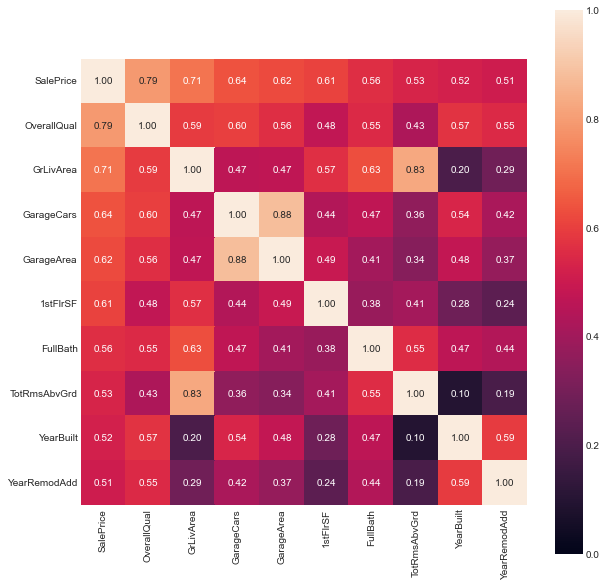

In [7]:
# plot features with largest correlation to SalePrice

high_corr_cols = PlotHighCorr(df_train, 'SalePrice')

In [8]:
# define a function to plot outlier

def PlotOutlier(data, data_outlier, cols, target):
    plt.figure(figsize=(10, 15))
    for i, c in enumerate(cols):
        plt.subplot(int(np.ceil(len(cols)/2)), 2, i+1)
        plt.scatter(c, target, data=data)
        plt.scatter(c, target, data=data_outlier, c='r')
        plt.xlabel(c)
        plt.ylabel(target)
    
    plt.tight_layout()
    plt.show()

769     3279
635     3395
1268    3447
304     3493
185     3608
1169    3627
691     4316
1182    4476
523     4676
1298    5642
Name: GrLivArea, dtype: int64


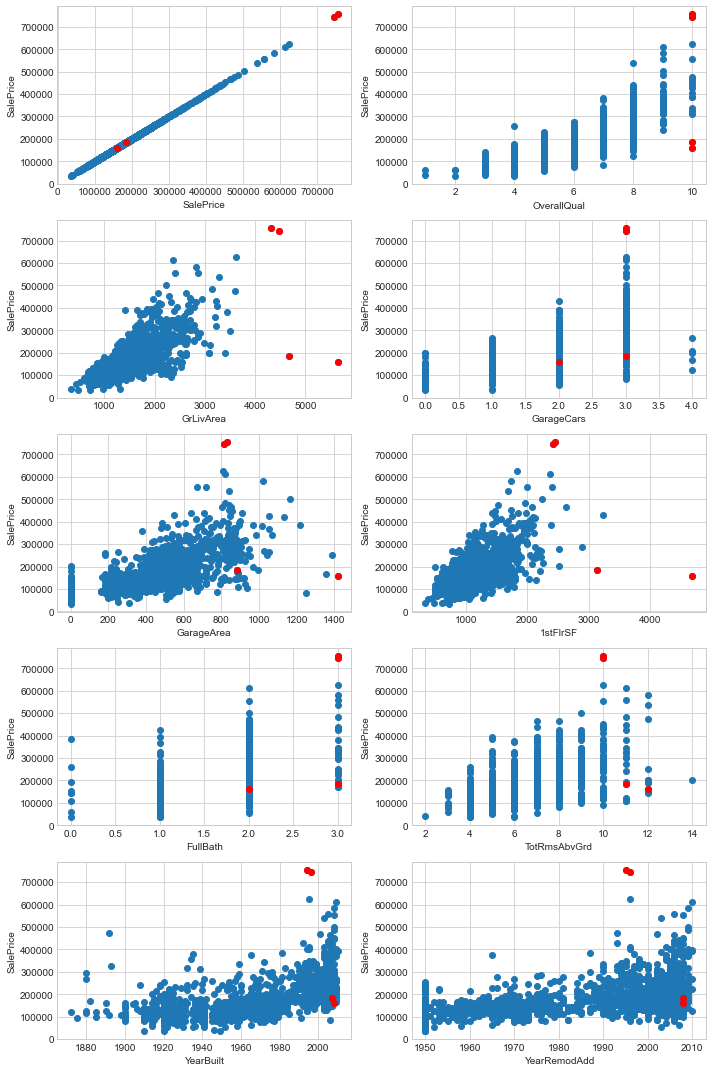

In [9]:
# search for outliers based on GrLivArea

print(df_train['GrLivArea'].sort_values()[-10:])     # observe the largest values of GrLivArea
outlier_index = df_train['GrLivArea'].sort_values()[-4:].index     # select four outliers from it
df_train_outlier = df_train.iloc[outlier_index]

PlotOutlier(df_train, df_train_outlier, high_corr_cols, 'SalePrice')

In [10]:
# outliers confirmed, delete them

df_train.drop(outlier_index, axis=0, inplace=True)

In [11]:
# determine features and target

X_train = df_train.drop(['Id', 'SalePrice'], axis=1)
y_train = df_train.SalePrice

X_test = df_test.drop('Id', axis=1)

cont = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 'LotArea',
        'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF',
        'PoolArea', 'ScreenPorch', 'WoodDeckSF'
       ]

disc = ['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'FullBath',
        'GarageCars', 'GarageYrBlt', 'HalfBath', 'KitchenAbvGr', 'MoSold',
        'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'YrSold'
       ]

nomi = ['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
        'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageType',
        'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType',
        'MiscFeature', 'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl',
        'RoofStyle', 'SaleCondition', 'SaleType'
       ]

ordi = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional',
        'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
        'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
        'PoolQC', 'Street', 'Utilities'
       ]

nume = cont + disc
cate = nomi + ordi

print('Number of continuous features:', len(cont))
print('Number of discrete features  :', len(disc))
print('Number of nominal features   :', len(nomi))
print('Number of ordinal features   :', len(ordi))
print('================================= +')
print('Total                        :', X_train.shape[1])

Number of continuous features: 18
Number of discrete features  : 14
Number of nominal features   : 23
Number of ordinal features   : 23
================================= +
Total                        : 78


In [12]:
# define functions to spot missing values

def MissVal(df):
    miss_sum = df.isnull().sum()
    miss_pct = df.isnull().sum() / df.isnull().count() * 100
    miss_val = pd.concat([miss_sum, miss_pct], axis=1, keys=['Total', 'Percentage'])
    miss_val = miss_val[miss_val.Total>0].sort_values(by='Total', ascending=False)
    return(miss_val)

def TableMissVal(train, test):
    miss_train = MissVal(train)
    miss_test = MissVal(test)
    miss_all = pd.concat([miss_train, miss_test], axis=1, sort=False)
    miss_all.columns = pd.MultiIndex.from_product([['miss_train', 'miss_test'], ['Total', 'Percentage']])
    miss_all.sort_values(by=[('miss_train', 'Total'), ('miss_test', 'Total')], ascending=False, inplace=True)
    return(miss_all)

In [13]:
# look for missing values

missing_values = TableMissVal(X_train, X_test)
missing_values

miss_train            miss_test           
                  Total Percentage     Total Percentage
PoolQC           1451.0  99.656593    1456.0  99.794380
MiscFeature      1402.0  96.291209    1408.0  96.504455
Alley            1365.0  93.750000    1352.0  92.666210
Fence            1176.0  80.769231    1169.0  80.123372
FireplaceQu       690.0  47.390110     730.0  50.034270
LotFrontage       259.0  17.788462     227.0  15.558602
GarageYrBlt        81.0   5.563187      78.0   5.346127
GarageFinish       81.0   5.563187      78.0   5.346127
GarageQual         81.0   5.563187      78.0   5.346127
GarageCond         81.0   5.563187      78.0   5.346127
GarageType         81.0   5.563187      76.0   5.209047
BsmtExposure       38.0   2.609890      44.0   3.015764
BsmtFinType2       38.0   2.609890      42.0   2.878684
BsmtCond           37.0   2.541209      45.0   3.084304
BsmtQual           37.0   2.541209      44.0   3.015764
BsmtFinType1       37.0   2.541209      42.0   2.878684
MasVnrType          8.0   0.549451      16.0   1.096642
MasVnrArea          8.0   0.549451      15.0   1.028101
Electrical          1.0   0.068681       NaN        NaN
MSZoning            NaN        NaN       4.0   0.274160
BsmtFullBath        NaN        NaN       2.0   0.137080
Functional          NaN        NaN       2.0   0.137080
BsmtHalfBath        NaN        NaN       2.0   0.137080
Utilities           NaN        NaN       2.0   0.137080
KitchenQual         NaN        NaN       1.0   0.068540
BsmtUnfSF           NaN        NaN       1.0   0.068540
GarageCars          NaN        NaN       1.0   0.068540
GarageArea          NaN        NaN       1.0   0.068540
BsmtFinSF2          NaN        NaN       1.0   0.068540
BsmtFinSF1          NaN        NaN       1.0   0.068540
Exterior2nd         NaN        NaN       1.0   0.068540
Exterior1st         NaN        NaN       1.0   0.068540
SaleType            NaN        NaN       1.0   0.068540

GarageCars and GarageArea miss on the same datapoint? True
Does garage exist at this datapoint? True
The median of GarageArea is 478.5
The median of GarageCars is 2.0


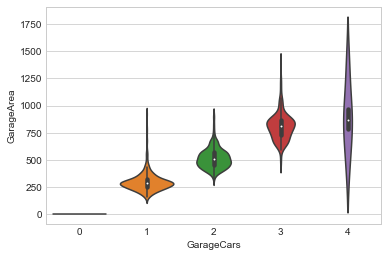

In [14]:
# handle missing values: GarageArea & GarageCars

print('GarageCars and GarageArea miss on the same datapoint?',
      X_test[X_test.GarageCars.isnull()].index.tolist() ==
      X_test[X_test.GarageArea.isnull()].index.tolist())

garage = ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt']
df_garage = X_test.iloc[X_test[X_test.GarageCars.isnull()].index][garage]
print('Does garage exist at this datapoint?', df_garage.notnull().values.any()) # use median?
print('The median of GarageArea is', X_train['GarageArea'].median()) # check median first
print('The median of GarageCars is', X_train['GarageCars'].median()) # check median first

sns.violinplot(x='GarageCars', y='GarageArea', data=X_train)
plt.show() # the median data fit, use median then

In [15]:
# categorize columns containing missing values

medi = ['GarageArea', 'GarageCars']
mode = ['Electrical', 'MSZoning', 'Functional', 'Utilities']
othe = ['GarageYrBlt', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
zero = [col for col in missing_values.index if ((col in nume) and (col not in othe+medi+mode))]
abse = [col for col in missing_values.index if ((col in cate) and (col not in othe+medi+mode))]

In [16]:
# manual imputation for GarageYrBlt

X_train.loc[X_train.GarageYrBlt.isnull(), 'GarageYrBlt'] = X_train.YearBuilt
X_test.loc[X_test.GarageYrBlt.isnull(), 'GarageYrBlt'] = X_test.YearBuilt

In [17]:
# missing value transformer

preprocessor_miss = DataFrameMapper(
    features =
        [([cols], SimpleImputer(strategy='median')) for cols in medi] +
        [([cols], SimpleImputer(strategy='most_frequent')) for cols in mode] +
        [([cols], SimpleImputer(strategy='constant', fill_value=0)) for cols in zero] +
        [([cols], SimpleImputer(strategy='constant', fill_value='No')) for cols in abse] +
        [(['KitchenQual'], SimpleImputer(strategy='constant', fill_value='TA')),
         (['Exterior1st'], SimpleImputer(strategy='constant', fill_value='Other')),
         (['Exterior2nd'], SimpleImputer(strategy='constant', fill_value='Other')),
         (['SaleType'], SimpleImputer(strategy='constant', fill_value='Oth'))],
    default = None,
    input_df = True,
    df_out = True
)

check_train = preprocessor_miss.fit_transform(X_train)
check_test = preprocessor_miss.transform(X_test)
print('X_train shape after imputation:', check_train.shape)
print('X_test shape after imputation :', check_test.shape)
display(MissVal(check_train))
display(MissVal(check_test))

X_train shape after imputation: (1456, 78)
X_test shape after imputation : (1459, 78)


,Total,Percentage


,Total,Percentage


In [18]:
# select 10 feature pairs with the largest corr

corrmat = X_train.corr().abs().unstack().sort_values(ascending=False)     # pearson correlation, is it suitable?
corrmat = corrmat[corrmat<1][:20]
corrmat = corrmat[[2*i for i in range(10)]]
print(corrmat)

corrmat_idx = []
for i, j in corrmat.index:
    corrmat_idx.append(i)
    corrmat_idx.append(j)
    
corrmat_idx = list(set(corrmat_idx))
print('High correlated columns:', corrmat_idx)

GarageArea    GarageCars      0.886882
YearBuilt     GarageYrBlt     0.844725
TotRmsAbvGrd  GrLivArea       0.833979
GrLivArea     2ndFlrSF        0.687430
BedroomAbvGr  TotRmsAbvGrd    0.679346
BsmtFinSF1    BsmtFullBath    0.661933
FullBath      GrLivArea       0.635161
GarageCars    GarageYrBlt     0.619292
2ndFlrSF      TotRmsAbvGrd    0.610794
HalfBath      2ndFlrSF        0.609022
dtype: float64
High correlated columns: ['GarageCars', 'HalfBath', 'BedroomAbvGr', 'YearBuilt', 'GarageArea', 'BsmtFinSF1', 'GarageYrBlt', 'FullBath', 'TotRmsAbvGrd', 'GrLivArea', '2ndFlrSF', 'BsmtFullBath']


In [19]:
# polynomial features transformer

preprocessor_polym = DataFrameMapper(
    features =
        [(corrmat_idx, PolynomialFeatures(degree=2))],
    default = None,
    input_df = True,
    df_out = True
)

check_train = preprocessor_polym.fit_transform(check_train)
check_test = preprocessor_polym.transform(check_test)
print('X_train shape after polynomization:', check_train.shape)
print('X_test shape after polynomization :', check_test.shape)

X_train shape after polynomization: (1456, 157)
X_test shape after polynomization : (1459, 157)


In [20]:
# get resulting columns of preprocessor_polym

col_polym = preprocessor_polym.transformed_names_[:91]

In [21]:
# revise the definition of nume after polynomization

nume = list(set(nume) - set(corrmat_idx))
nume = nume + col_polym
print('Number of numerical columns after polynomization:', len(nume))

Number of numerical columns after polynomization: 111


In [22]:
# scaling and encoding transformers

preprocessor_encode = DataFrameMapper(
    features = 
        [([cols], StandardScaler()) for cols in nume] +
        [([cols], LabelEncoder()) for cols in ordi] +
        [([cols], OneHotEncoder(handle_unknown='ignore')) for cols in nomi],
    default = None,
    input_df = True,
    df_out = True
)

check_train = preprocessor_encode.fit_transform(check_train)
check_test = preprocessor_encode.transform(check_test)
print('X_train shape after encoding:', check_train.shape)
print('X_test shape after encoding :', check_test.shape)

X_train shape after encoding: (1456, 318)
X_test shape after encoding : (1459, 318)


In [23]:
# build preprocessing pipeline

preprocessor = Pipeline([
    ('pre_miss', preprocessor_miss),
    ('pre_polym', preprocessor_polym),
    ('pre_encode', preprocessor_encode)
])

X_train_branch = X_train     # branch of X_train for other processing
X_test_branch = X_test     # branch of X_test for other processing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('X_train shape after preprocessed:', X_train.shape)
print('X_test shape after preprocessed :', X_test.shape)

X_train shape after preprocessed: (1456, 318)
X_test shape after preprocessed : (1459, 318)


In [24]:
# build preprocessing pipeline

nume = cont + disc

preprocessor_encode = DataFrameMapper(
    features = 
        [([cols], StandardScaler()) for cols in nume] +
        [([cols], LabelEncoder()) for cols in ordi] + 
        [([cols], OneHotEncoder(handle_unknown='ignore')) for cols in nomi],
    default = None,
    input_df = True,
    df_out = True
)

preprocessor2 = Pipeline([
    ('pre_miss', preprocessor_miss),
    ('pre_encode', preprocessor_encode)
])

X_train_branch = preprocessor2.fit_transform(X_train_branch)
X_test_branch = preprocessor2.transform(X_test_branch)
print('X_train shape after preprocessed:', X_train_branch.shape)
print('X_test shape after preprocessed :', X_test_branch.shape)

X_train shape after preprocessed: (1456, 239)
X_test shape after preprocessed : (1459, 239)


In [25]:
# transform SalePrice

y_train = np.log1p(y_train)

In [26]:
# export pre-processed data

pd.concat([X_train, y_train], axis=1).to_csv('train_preprocessed.csv', index=False)
X_test.to_csv('test_preprocessed.csv', index=False)

In [27]:
# export pre-processed data

pd.concat([X_train_branch, y_train], axis=1).to_csv('train_preprocessed_branch.csv', index=False)
X_test_branch.to_csv('test_preprocessed_branch.csv', index=False)

# Modeling

In [28]:
# read files

df_train = pd.read_csv('train_preprocessed.csv')
df_test = pd.read_csv('test_preprocessed.csv')
df_train_branch = pd.read_csv('train_preprocessed_branch.csv')
df_test_branch = pd.read_csv('test_preprocessed_branch.csv')

In [29]:
# split target

X_train = df_train.iloc[:,:-1]
y_train = np.ravel(df_train.iloc[:,-1:])
X_test = df_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
n_features = X_train.shape[1]

X_train_branch = df_train_branch.iloc[:,:-1]
y_train = np.ravel(df_train_branch.iloc[:,-1:])
X_test_branch = df_test_branch
print(X_train_branch.shape)
print(y_train.shape)
print(X_test_branch.shape)
n_features_branch = X_train_branch.shape[1]

(1456, 318)
(1456,)
(1459, 318)
(1456, 239)
(1456,)
(1459, 239)


In [30]:
# define metrics

def custom_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return(rmse)

score = make_scorer(custom_metrics, greater_is_better=False)

In [31]:
# base model

lr = GridSearchCV(LinearRegression(),
                  param_grid = {'normalize': [True, False]},
                  scoring = score,
                  n_jobs = -1,
                  cv = 5,
                  verbose = 1)
lr.fit(X_train, y_train)
print('Best parameters:', lr.best_params_)
print('Best score:', -lr.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'normalize': False}
Best score: 0.13793945749810943


In [32]:
# initialize prediction of models

predictions = []

## Linear Model

### Ridge

In [33]:
# build, fit, & predict

ridge = RidgeCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                          0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6,
                          10, 30, 60],
                scoring = score,
                cv = 5)
ridge.fit(X_train, y_train)
print('Best alpha:', ridge.alpha_)

ridge = RidgeCV(alphas = [15, 20, 25, 30, 35, 40, 45, 50, 55],
                scoring = score,
                cv = 5)
ridge.fit(X_train, y_train)
print('Best alpha:', ridge.alpha_)

y_pred = ridge.predict(X_test)
predictions.append(np.expm1(y_pred))

Best alpha: 30.0
Best alpha: 25


### Lasso

In [34]:
# build, fit, & predict

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                          0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                max_iter = 1000000,
                cv = 5,
                verbose=1,
                n_jobs=-1,
                random_state=RS)
lasso.fit(X_train, y_train)
print('Best alpha:', lasso.alpha_)
print('Number of iterations:', lasso.n_iter_)

lasso = LassoCV(alphas = [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009],
                max_iter = 1000000,
                cv = 5,
                verbose=1,
                n_jobs=-1,
                random_state=RS)
lasso.fit(X_train, y_train)
print('Best alpha:', lasso.alpha_)
print('Number of iterations:', lasso.n_iter_)

y_pred = lasso.predict(X_test)
predictions.append(np.expm1(y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
...........................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Best alpha: 0.0006
Number of iterations: 1859


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
..............................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Best alpha: 0.0005
Number of iterations: 5098


### ElasticNet

In [35]:
# build, fit, & predict

elastic_net = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 1],
                           alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                                     0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                           max_iter = 1000000,
                           cv = 5,
                           verbose=1,
                           n_jobs=-1,
                           random_state=RS)
elastic_net.fit(X_train, y_train)
print('Best alpha   :', elastic_net.alpha_)
print('Best l1 ratio:', elastic_net.l1_ratio_)
print('Number of iterations:', elastic_net.n_iter_)

elastic_net = ElasticNetCV(l1_ratio = [0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94],
                           alphas = [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009],
                           max_iter = 1000000,
                           cv = 5,
                           verbose=1,
                           n_jobs=-1,
                           random_state=RS)
elastic_net.fit(X_train, y_train)
print('Best alpha   :', elastic_net.alpha_)
print('Best l1 ratio:', elastic_net.l1_ratio_)
print('Number of iterations:', elastic_net.n_iter_)

y_pred = elastic_net.predict(X_test)
predictions.append(np.expm1(y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
........................................................................................................................................................................................................................................................................................................................................................

Best alpha   : 0.0006
Best l1 ratio: 0.9
Number of iterations: 4589


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
..............................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished


Best alpha   : 0.0006
Best l1 ratio: 0.86
Number of iterations: 5756


### LassoLars

In [36]:
# build, fit, & predict

lasso_lars = GridSearchCV(LassoLars(max_iter=500, eps=1e-7),
                          param_grid = {'alpha': [1e-6, 3e-6, 6e-6, 1e-5, 3e-5, 6e-5,
                                                  1e-4, 3e-4, 6e-4, 1e-3, 3e-3, 6e-3,
                                                  0.01, 0.03, 0.06],
                                        'normalize': [True, False],
                                        'fit_intercept': [True, False]},
                          scoring = score,
                          n_jobs = -1,
                          cv = 5,
                          verbose = 1)
lasso_lars.fit(X_train, y_train)
print('Best parameters:', lasso_lars.best_params_)
print('Best score:', -lasso_lars.best_score_)

lasso_lars = GridSearchCV(LassoLars(max_iter=500, eps=1e-7),
                          param_grid = {'alpha': [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009],
                                        'normalize': [True, False],
                                        'fit_intercept': [True, False]},
                          scoring = score,
                          n_jobs = -1,
                          cv = 5,
                          verbose = 1)
lasso_lars.fit(X_train, y_train)
print('Best parameters:', lasso_lars.best_params_)
print('Best score:', -lasso_lars.best_score_)

y_pred = lasso_lars.predict(X_test)
predictions.append(np.expm1(y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'alpha': 0.0003, 'fit_intercept': True, 'normalize': False}
Best score: 0.11257907088569175
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'alpha': 0.0004, 'fit_intercept': True, 'normalize': False}
Best score: 0.11254944448874578


### OrthogonalMatchingPursuit

In [37]:
# build, fit, & predict

omp = GridSearchCV(OrthogonalMatchingPursuit(),
                   param_grid = {'n_nonzero_coefs': [i+1 for i in range(100)],
                                 'normalize': [True, False],
                                 'fit_intercept': [True, False]},
                   scoring = score,
                   n_jobs = -1,
                   cv = 5,
                   verbose = 1)
omp.fit(X_train, y_train)
print('Best parameters:', omp.best_params_)
print('Best score:', -omp.best_score_)

y_pred = omp.predict(X_test)
predictions.append(np.expm1(y_pred))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'fit_intercept': True, 'n_nonzero_coefs': 76, 'normalize': False}
Best score: 0.11606350636373641


## SVM Models

### SVR

In [38]:
# build, fit, & predict

svr = GridSearchCV(SVR(gamma='scale'),
                   param_grid = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
                                 "epsilon": [0, 1e-3, 1e-2, 1e-1, 1e0]},
                   scoring = score,
                   n_jobs = -1,
                   cv = 5,
                   verbose = 1)

svr.fit(X_train, y_train)
print('Best parameters:', svr.best_params_)
print('Best score:', -svr.best_score_)

svr = GridSearchCV(SVR(gamma='scale'),
                   param_grid = {"C": [0.8, 0.9, 1, 2, 3],
                                 "epsilon": [0.008, 0.009, 0.01, 0.02, 0.03]},
                   scoring = score,
                   n_jobs = -1,
                   cv = 5,
                   verbose = 1)

svr.fit(X_train, y_train)
print('Best parameters:', svr.best_params_)
print('Best score:', -svr.best_score_)
y_pred = svr.predict(X_test)
predictions.append(np.expm1(y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'C': 1.0, 'epsilon': 0.01}
Best score: 0.11663181040297455
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'C': 2, 'epsilon': 0.01}
Best score: 0.11655057762624019


### NuSVR

In [39]:
# build, fit, & predict

nu_svr = GridSearchCV(NuSVR(gamma='scale'),
                     param_grid = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
                                   "nu": [1e-2, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
                     scoring = score,
                     n_jobs = -1,
                     cv = 5,
                     verbose = 1)

nu_svr.fit(X_train, y_train)
print('Best parameters:', nu_svr.best_params_)
print('Best score:', -nu_svr.best_score_)

nu_svr = GridSearchCV(NuSVR(gamma='scale'),
                     param_grid = {"C": [0.8, 0.9, 1, 2, 3],
                                   "nu": [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]},
                     scoring = score,
                     n_jobs = -1,
                     cv = 5,
                     verbose = 1)

nu_svr.fit(X_train, y_train)
print('Best parameters:', nu_svr.best_params_)
print('Best score:', -nu_svr.best_score_)
y_pred = nu_svr.predict(X_test)
predictions.append(np.expm1(y_pred))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'C': 1.0, 'nu': 0.7}
Best score: 0.11676650321032314
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'C': 1, 'nu': 0.6}
Best score: 0.11658491739642962


# Post-processing

In [40]:
# define a function to plot learning curve

def PlotLearningCurve(estimator, title, X, y, score, ylim=None, cv=None,
                      n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
        """
        Generate a simple plot of the test and training learning curve.

        Parameters
        ----------
        estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

        title : string
            Title for the chart.

        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : int, cross-validation generator or an iterable, optional
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:
              - None, to use the default 3-fold cross-validation,
              - integer, to specify the number of folds.
              - :term:`CV splitter`,
              - An iterable yielding (train, test) splits as arrays of indices.

            For integer/None inputs, if ``y`` is binary or multiclass,
            :class:`StratifiedKFold` used. If the estimator is not a classifier
            or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

            Refer :ref:`User Guide <cross_validation>` for the various
            cross-validators that can be used here.

        n_jobs : int or None, optional (default=None)
            Number of jobs to run in parallel.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.

        train_sizes : array-like, shape (n_ticks,), dtype float or int
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the dtype is float, it is regarded as a
            fraction of the maximum size of the training set (that is determined
            by the selected validation method), i.e. it has to be within (0, 1].
            Otherwise it is interpreted as absolute sizes of the training sets.
            Note that for classification the number of samples usually have to
            be big enough to contain at least one sample from each class.
            (default: np.linspace(0.1, 1.0, 5))
        """
        plt.figure()
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, scoring=score, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(-train_scores, axis=1)
        train_scores_std = np.std(-train_scores, axis=1)
        test_scores_mean = np.mean(-test_scores, axis=1)
        test_scores_std = np.std(-test_scores, axis=1)
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        plt.title(title + '\nCross-validation score: ' + str(round(test_scores_mean[-1], 4)))
        return plt

In [41]:
# define models

models = {}
models['Ridge'] = Ridge(alpha=ridge.alpha_)
models['Lasso'] = Lasso(alpha=lasso.alpha_, max_iter=lasso.n_iter_)
models['Elastic Net'] = ElasticNet(alpha=elastic_net.alpha_, l1_ratio=elastic_net.l1_ratio_, max_iter=elastic_net.n_iter_)
models['Lasso LARS'] = lasso_lars.best_estimator_
models['OMP'] = omp.best_estimator_
models['SVR'] = svr.best_estimator_
models['NuSVR'] = nu_svr.best_estimator_
print('Number of models:', len(models))

Number of models: 7


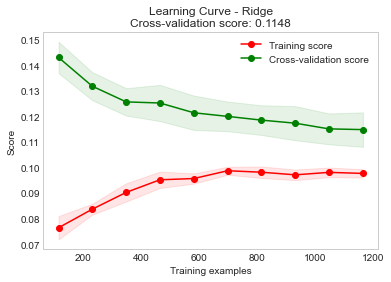

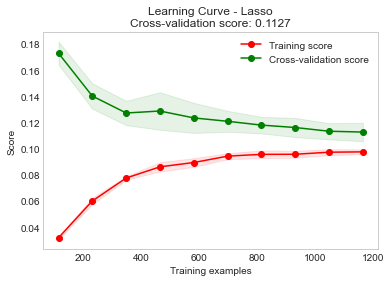

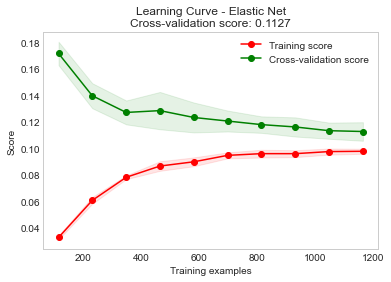

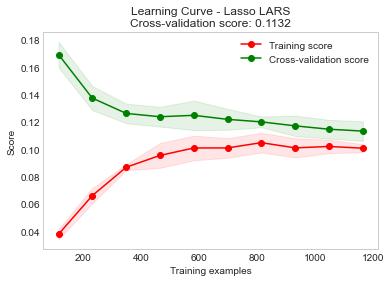

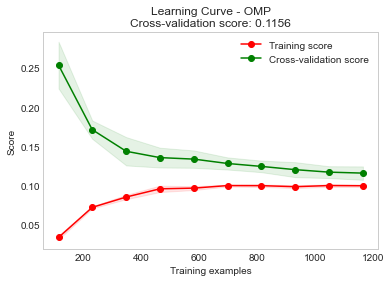

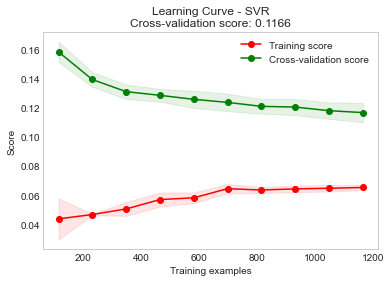

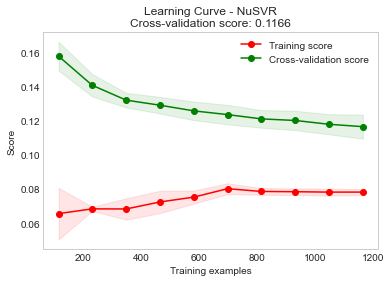

In [42]:
# plot learning curve

for i, model in models.items():
    PlotLearningCurve(model, 
                      title = 'Learning Curve - ' + i, 
                      X = X_train, 
                      y = y_train,
                      score = score,
                      cv = 5)

plt.show()

In [43]:
# export prediction

y_pred_final = (predictions[0] + predictions[1] + predictions[2] + predictions[3] + predictions[4] + \
                predictions[5] + predictions[6]) / 7
output = pd.DataFrame({'Id':df_test_ids, 'SalePrice':y_pred_final})
output.to_csv('result.csv', index=False)